In [11]:
import numpy as np
import pandas as pd
import editdistance
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tqdm import tqdm

In [2]:
#register = 'reg01'
registers = ['reg01', 'reg02', 'reg03', 'reg04', 'reg05', 'reg06', 'reg06bis', 'reg07']
encoding = 'utf-8'
#path_segmentation = os.path.join('/dhlabdata4/mion/P2PaLA/sommarioniProcessed', register)
path_segmentation = '/dhlabdata4/mion/P2PaLA/sommarioniProcessed'
#path_htr = os.path.join('/dhlabdata4/mion/PyLaia/egs/decipher-venice/data/sommarioni',register)
path_htr = '/dhlabdata4/mion/PyLaia/egs/decipher-venice/data/sommarioni'
#path_original_img = os.path.join('/dhlabdata4/sommarioni', register)
path_original_img = '/dhlabdata4/sommarioni'
path_test_set = '/dhlabdata4/mion/VeniceTimeMachineSommarioniHTR/Test_set/sommarioni_cleaned_gt.tsv'

In [3]:
def replace_quondam(s):
    return s.replace('quondam', 'q.')

def clean_excel(excel):
    excel["denom_pezzi_di_terra"] = excel["denom_pezzi_di_terra"].apply(lambda x: str(x).replace(";", " "))
    excel["possessore"] = excel["possessore"].apply(lambda x: replace_quondam(str(x)))
    return excel.drop(columns=['Unnamed: 0'])

def clean_result_htr(result_htr):
    result_htr["cleaned"] = result_htr["cleaned"].apply(lambda x: replace_quondam(str(x)))
    result_htr = result_htr.dropna()
    result_htr = result_htr[result_htr['cleaned']!='nan']
    result_htr['id'] = result_htr["id"].apply(lambda x: str(x)+'.jpg')
    return result_htr

def clean_metadata(metadata):
    # the page name must finish with a number
    metadata['last_token'] = metadata['page_name'].str.split('_').apply(lambda x : x[-1].split('.')[0])
    metadata = metadata[metadata['last_token'].str.isnumeric()==True].drop(columns=['last_token'])
    return metadata.drop(columns=['Unnamed: 0'])

In [208]:
excel = clean_excel(pd.read_excel('sommarioni_cleaned_original.xlsx'))
#result_htr = clean_result_htr(pd.read_csv(os.path.join(path_htr,'patches191120.csv')))
#result_htr = clean_result_htr(pd.read_csv(os.path.join(path_htr,'patches251120.csv')))
result_htr = pd.DataFrame()
metadata = pd.DataFrame()
htr_metadata = pd.DataFrame()

for register in registers:
    path_htr_register = os.path.join(path_htr,register)
    path_segmentation_htr = os.path.join(path_segmentation, register)
    result_htr_reg = clean_result_htr(pd.read_csv(os.path.join(path_htr_register,'patches_'+register+'.csv')))
#metadata_path = os.path.join(path_segmentation,'results/prod/dataframes')
    metadata_path = os.path.join(path_segmentation_htr,'results/prod/dataframe')
    csv_files=os.listdir(metadata_path)
    metadata_reg = pd.read_csv(os.path.join(metadata_path,csv_files[0]), encoding=encoding)
    for f  in csv_files[1:]:
        metadata_reg = metadata_reg.append(pd.read_csv(os.path.join(metadata_path,f), encoding=encoding))
    metadata_reg = clean_metadata(metadata_reg)
    htr_metadata_reg = result_htr_reg.join(metadata_reg.set_index('filename'), on='id', how='inner')
    htr_metadata_reg['register'] = register
    
    result_htr = result_htr.append(result_htr_reg)
    metadata = metadata.append(metadata_reg) 
    htr_metadata = htr_metadata.append(htr_metadata_reg)
htr_metadata['collumn_number']=htr_metadata['collumn_number'].astype(int)     

In [5]:
htr_metadata.head()

,id,cleaned,x_min,x_max,y_min,y_max,collumn_number,patch_number,page_name,register
0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,c,3416,3481,4031,4168,7,1.0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,reg01
1,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,2032. 33. 34. 35,1851,2466,2904,3045,4,2.0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,reg01
2,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,2023 202,1855,2264,4494,4628,4,1.0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,reg01
3,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,1,3477,3552,3719,3867,7,1.0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,reg01
4,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,2030,1923,2084,3088,3225,4,1.0,Censo-stabile_Sommarioni-napoleonici_reg-1_008...,reg01


In [6]:
excel.head()

,place_acronym,numero_della_mappa,subalterno,corr_as,corr_ai,place,denom_pezzi_di_terra,possessore,qualita
0,NSM,1,NaN,ASM 2121 ASM 2122,AISM 2121 AISM 2122,SM - Parrocchia di S. Fantino,3205 3206,PAGANI - Concorso de' creditori,Casa d'affitto
1,NSM,2,1,ASM 2124,AISM 2124,SM - Parrocchia di S. Fantino,3207,TIEPOLO Gerolamo q. Almorò,Casa d'affitto
2,NSM,2,2,ASM 2124,AISM 2124,SM - Parrocchia di S. Fantino,nan,PAGANI - Concorso come sopra al N° 1 [de' cred...,Casa d'affitto
3,NSM,3,1,ASM 2123,AISM 2123,SM - Parrocchia di S. Fantino,3208,BELLI Angelo Livellario di Lorenzo Tiepolo,Bottega unica a proprio uso
4,NSM,3,2,ASM 2123,AISM 2123,SM - Parrocchia di S. Fantino,3209,TIEPOLO Lorenzo q. Almorò,Superiori d'affitto


In [ ]:
htr_metadata[htr_metadata['register']=='reg02']

In [ ]:
# TEST on one page
pageID = 'Censo-stabile_Sommarioni-napoleonici_reg-1_0015_013'
path_image = os.path.join(path_original_img, pageID+'.jpg')
metadata = metadata[metadata['page_name']==pageID]
htr_metadata = htr_metadata[htr_metadata['page_name']==pageID]
result_htr = result_htr[result_htr['id'].str.contains(pageID)]

In [209]:
htr_metadata = htr_metadata.reset_index()\
                           .drop(columns=['index'])

In [9]:
def remove_numeric_htr_result(result_htr):
    return result_htr[result_htr['cleaned'].str.isnumeric()==False]
def remove_one_letter_htr_result(result_htr):
    return result_htr[result_htr['cleaned'].str.len() > 1]

#result_htr = remove_one_letter_htr_result(remove_numeric_htr_result(result_htr))\
#                                        .reset_index()\
#                                        .drop(columns=['index'])

In [10]:
def extract_numero_della_mappa(htr_metadata):
    numero_della_mappa = pd.DataFrame(htr_metadata[htr_metadata['collumn_number']==1])
    numero_della_mappa['cleaned'] = numero_della_mappa['cleaned'].apply(lambda x : x.replace('.',''))
    return numero_della_mappa[numero_della_mappa['cleaned'].str.isnumeric()]

In [13]:
def extract_column_htr(htr_data, col_number):
    return htr_data[htr_data['collumn_number']==col_number]['cleaned']

def stats_length_column(htr_data, col_number):
    col = extract_column_htr(htr_data, col_number)
    return col.apply(lambda x : len(str(x))).describe()

def mean_length_column(htr_data, col_number):
    stats = stats_length_column(htr_data, col_number)
    if 'mean' in stats:
        return stats['mean']
    return np.NaN

def mean_length_colum_vector(htr_data):
    vector = {}
    for c in range(htr_data['collumn_number'].max()+1):
        vector[c] = mean_length_column(htr_data, c)
    return vector

In [14]:
def print_all_mean(htr_data):
    for c in range(htr_data['collumn_number'].max()+1):
        print('Mean length col', c,':',mean_length_column(htr_data, c))
print_all_mean(htr_metadata)

Mean length col 0 : 4.184821786143372
Mean length col 1 : 4.1966434132039225
Mean length col 2 : 6.590134529147982
Mean length col 3 : 16.749413533834588
Mean length col 4 : 9.984740836428225
Mean length col 5 : 13.868461948832138
Mean length col 6 : 10.110220797720798
Mean length col 7 : 7.348671544089334
Mean length col 8 : 3.6079613992762365
Mean length col 9 : 3.2639885222381637
Mean length col 10 : 3.5580912863070537
Mean length col 11 : 3.2244897959183674
Mean length col 12 : 3.0
Mean length col 13 : 2.7
Mean length col 14 : 3.0
Mean length col 15 : 10.0
Mean length col 16 : 21.0


In [ ]:
num_prob = 0
for page in sorted(htr_metadata['page_name'].unique()):
    page_htr_metatada = htr_metadata[htr_metadata['page_name']==page]
    
    
    length_col3 = mean_length_column(page_htr_metatada, 3)
    if length_col3 < 5:
        num_prob += 1
        print(page)
        
        print_all_mean(page_htr_metatada)
        
print('#problematic pages : ', num_prob)

In [15]:
def mean_length_matrix(htr_metadata):
    feature_m=[]
    for page in tqdm(sorted(htr_metadata['page_name'].unique())):    
        page_htr_metatada = htr_metadata[htr_metadata['page_name']==page]

        feature_v = mean_length_colum_vector(page_htr_metatada)
        feature_v['page_name'] = page
        feature_m.append(feature_v)

    return pd.DataFrame(feature_m).set_index('page_name')
page_matrix = mean_length_matrix(htr_metadata)

100%|██████████| 1613/1613 [00:42<00:00, 38.05it/s]


In [16]:
def plot_pca(matrix, axe, hue=0):
    X_pca = PCA(n_components=2).fit_transform(matrix.fillna(0))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],hue=hue, legend='full', hue_order= ['Aligned','Skewed'], ax=axe)

100%|██████████| 198/198 [00:04<00:00, 41.61it/s]


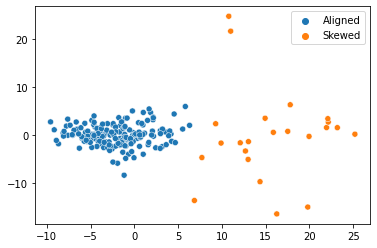

In [156]:
fig, axes = plt.subplots(1,1)
matrix = mean_length_matrix(htr_metadata[htr_metadata['register']=='reg01'])
kmeans = KMeans(n_clusters=2).fit(matrix[[0,1,2,3,4,5,6,7,8]].fillna(0))
aligned_cluster = np.argmax(np.bincount(kmeans.labels_))
skewed_cluster = int(not aligned_cluster)
legend_map = {aligned_cluster:'Aligned', skewed_cluster:'Skewed'}
labels = list(map(lambda x:legend_map[x], kmeans.labels_))
    
plot_pca(matrix[[0,1,2,3,4,5,6,7,8]], axes, labels)

In [157]:
matrix['cluster']=labels

In [158]:
matrix[matrix['cluster']=='Skewed']

,0,1,2,3,4,5,6,7,8,9,10,11,cluster
page_name,,,,,,,,,,,,,
Censo-stabile_Sommarioni-napoleonici_reg-1_0015_013,7.000000,NaN,3.800000,3.666667,19.423077,9.535714,17.681818,5.000000,8.000000,4.5,1.000000,NaN,Skewed
Censo-stabile_Sommarioni-napoleonici_reg-1_0017_015,NaN,3.777778,3.461538,11.590909,17.640000,14.380952,15.818182,9.800000,7.142857,2.0,NaN,NaN,Skewed
Censo-stabile_Sommarioni-napoleonici_reg-1_0021_019,4.000000,4.250000,4.230769,17.100000,17.928571,9.000000,10.823529,5.142857,2.500000,1.0,2.000000,NaN,Skewed
Censo-stabile_Sommarioni-napoleonici_reg-1_0038_036,1.200000,5.000000,5.000000,8.000000,9.666667,7.000000,5.000000,4.800000,4.666667,NaN,5.000000,NaN,Skewed
Censo-stabile_Sommarioni-napoleonici_reg-1_0039_037,5.500000,4.750000,3.500000,3.800000,4.700000,2.400000,5.000000,6.000000,4.333333,5.0,NaN,NaN,Skewed
Censo-stabile_Sommarioni-napoleonici_reg-1_0041_039,2.840000,3.000000,13.482759,5.923077,14.086957,4.000000,3.666667,3.400000,2.000000,NaN,NaN,NaN,Skewed
Censo-stabile_Sommarioni-napoleonici_reg-1_0053_051,11.000000,3.625000,2.692308,9.800000,16.560000,6.636364,5.117647,5.750000,3.333333,2.0,NaN,NaN,Skewed
Censo-stabile_Sommarioni-napoleonici_reg-1_0061_059,10.333333,3.000000,3.125000,9.777778,15.809524,6.518519,8.500000,4.000000,6.750000,4.0,NaN,2.0,Skewed
Censo-stabile_Sommarioni-napoleonici_reg-1_0064_062,1.000000,4.500000,7.000000,8.000000,6.200000,2.333333,3.000000,3.500000,2.000000,NaN,NaN,NaN,Skewed


In [46]:
legend_map

{1: 'Aligned', 0: 'Skewed'}

In [28]:
matrix['cluster']=labels
matrix[matrix['cluster']=='Skewed'].iloc[0]

0                7
1              NaN
2              3.8
3          3.66667
4          19.4231
5          9.53571
6          17.6818
7                5
8                8
9              4.5
10               1
11             NaN
cluster     Skewed
Name: Censo-stabile_Sommarioni-napoleonici_reg-1_0015_013, dtype: object

In [135]:
def extract_vector(row):
    #vector = matrix.fillna(0).iloc[index].drop('cluster')
    #return np.array(vector).reshape((1,-1))
    return np.array(row.drop('cluster')).reshape((1,-1))
def roll_left(vector, means):
    rolled = np.roll(vector, shift=-1)
    rolled[:,-1]=means[-1]
    return rolled

def roll_right(vector, means):
    rolled = np.roll(vector, shift=1)
    rolled[:,0] = means[0]
    return rolled

In [112]:
means = mean_length_colum_vector(htr_metadata[htr_metadata['register']=='reg01'])
means

{0: 4.115864527629234,
 1: 4.051905626134301,
 2: 4.943117178612059,
 3: 19.566046621144338,
 4: 8.856288751107174,
 5: 15.955492424242424,
 6: 4.9677615571776155,
 7: 4.977331606217617,
 8: 3.591292134831461,
 9: 3.066390041493776,
 10: 3.3333333333333335,
 11: 2.8}

In [126]:
vector = extract_vector(matrix[matrix['cluster']=='Skewed'], 0)
lefted = roll_left(vector, [means[col] for col in means])
righted = roll_right(vector, [means[col] for col in means])

In [ ]:
means = mean_length_colum_vector(htr_metadata[htr_metadata['register']=='reg01'])



In [127]:
vector

array([[7.0, 0.0, 3.8, 3.6666666666666665, 19.423076923076923,
        9.535714285714286, 17.681818181818183, 5.0, 8.0, 4.5, 1.0, 0.0]],
      dtype=object)

In [128]:
lefted

array([[0.0, 3.8, 3.6666666666666665, 19.423076923076923,
        9.535714285714286, 17.681818181818183, 5.0, 8.0, 4.5, 1.0, 0.0,
        2.8]], dtype=object)

In [129]:
righted

array([[4.115864527629234, 7.0, 0.0, 3.8, 3.6666666666666665,
        19.423076923076923, 9.535714285714286, 17.681818181818183, 5.0,
        8.0, 4.5, 1.0]], dtype=object)

In [130]:
kmeans.predict(vector)

array([0], dtype=int32)

In [131]:
kmeans.predict(lefted)

array([1], dtype=int32)

In [132]:
kmeans.predict(righted)

array([1], dtype=int32)

In [205]:
def computes_fixex(htr_metadata, matrix, kmeans,legend_map):
    means = mean_length_colum_vector(htr_metadata[htr_metadata['register']=='reg01'])
    means = [means[col] for col in means]
    matrix = matrix[matrix['cluster']=='Skewed'].fillna(0)
    fixes = {}
    for i, row in matrix.iterrows():
        vector = extract_vector(row)
        rolled_left = roll_left(vector, means)

        pred = kmeans.predict(rolled_left[:,:9])
        if legend_map[pred[0]]=='Aligned':
            fixes[i] = 'LEFT'
        else:
            rolled_right = roll_right(vector, means)
            pred = kmeans.predict(rolled_right[:,:9])
            if legend_map[pred[0]]=='Aligned':
                fixes[i] ='RIGHT'
            else:
                fixes[i] ='NO'
    return fixes

In [207]:
def apply_fixex(htr_metadata, fixes):
    for page in fixes:
        index = htr_metadata['page_name']==page
        if fixes[page] =='LEFT':
            htr_metadata.loc[index,'collumn_number'] = htr_metadata.loc[index,'collumn_number'].apply(lambda x: x-1)
        elif fixes[page] == 'RIGHT':
            htr_metadata.loc[index,'collumn_number'] = htr_metadata.loc[index,'collumn_number'].apply(lambda x: x+1)
    return htr_metadata        

In [206]:
def filter_columns(htr_metadata):
    return htr_metadata[(htr_metadata['collumn_number']>=0)& (htr_metadata['collumn_number']<=8)]

In [171]:
fixes

{'Censo-stabile_Sommarioni-napoleonici_reg-1_0015_013': 'LEFT',
 'Censo-stabile_Sommarioni-napoleonici_reg-1_0017_015': 'LEFT',
 'Censo-stabile_Sommarioni-napoleonici_reg-1_0021_019': 'NO',
 'Censo-stabile_Sommarioni-napoleonici_reg-1_0038_036': 'NO',
 'Censo-stabile_Sommarioni-napoleonici_reg-1_0039_037': 'NO',
 'Censo-stabile_Sommarioni-napoleonici_reg-1_0041_039': 'RIGHT fix',
 'Censo-stabile_Sommarioni-napoleonici_reg-1_0053_051': 'NO',
 'Censo-stabile_Sommarioni-napoleonici_reg-1_0061_059': 'NO',
 'Censo-stabile_Sommarioni-napoleonici_reg-1_0064_062': 'NO',
 'Censo-stabile_Sommarioni-napoleonici_reg-1_0073_071': 'RIGHT fix',
 'Censo-stabile_Sommarioni-napoleonici_reg-1_0077_075': 'RIGHT fix',
 'Censo-stabile_Sommarioni-napoleonici_reg-1_0093_091': 'LEFT',
 'Censo-stabile_Sommarioni-napoleonici_reg-1_0095_093': 'LEFT',
 'Censo-stabile_Sommarioni-napoleonici_reg-1_0129_127': 'NO',
 'Censo-stabile_Sommarioni-napoleonici_reg-1_0130_128': 'NO',
 'Censo-stabile_Sommarioni-napoleonici_re

In [ ]:
fig, axes = plt.subplots(4,2, figsize=(20,20), squeeze=False)
plot_line = 0
pages=[]
for i,register in enumerate(registers):
    matrix = mean_length_matrix(htr_metadata[htr_metadata['register']==register])
    kmeans = KMeans(n_clusters=2).fit(matrix.fillna(0))
    aligned_cluster = np.argmax(np.bincount(kmeans.labels_))
    skewed_cluster = int(not aligned_cluster)
    legend_map = {aligned_cluster:'Aligned', skewed_cluster:'Skewed'}
    labels = list(map(lambda x:legend_map[x], kmeans.labels_))
    
    plot_col = i%2
    plot_pca(matrix, axes[plot_line,plot_col], labels)
    
    matrix['cluster']=labels
    pages = pages + sorted(list(matrix[matrix['cluster']=='Aligned'].reset_index()['page_name']))
    
    if plot_col == 1:
        plot_line+=1

In [ ]:
num_prob = 0
for page in sorted(htr_metadata['page_name'].unique()):
    page_htr_metatada = htr_metadata[htr_metadata['page_name']==page]
    
    
    length_col3 = mean_length_column(page_htr_metatada, 3)
    if length_col3 < 7:
        print('Cluster :',page_matrix[page_matrix['page_name']==page].iloc[0]['cluster'])
        num_prob += 1
        print(page)
        
        print_all_mean(page_htr_metatada)
        
print('#problematic pages : ', num_prob)

In [200]:
pageID = 'Censo-stabile_Sommarioni-napoleonici_reg-1_0005_003'
path_original_img_reg = os.path.join(path_original_img, 'reg01')
path_image = os.path.join(path_original_img_reg, pageID+'.jpg')

In [ ]:
test = htr_metadata[htr_metadata['page_name']==pageID]
test[test['collumn_number']==0]

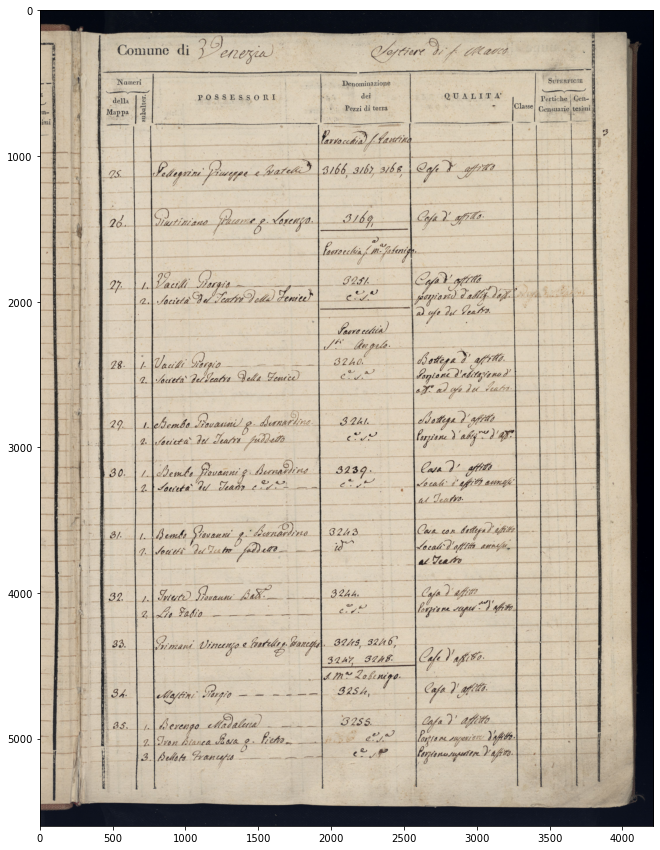

In [201]:
img = mpimg.imread(path_image)
fig= plt.figure(figsize=(20,15))
plt.imshow(img) 
plt.show()

In [ ]:
def format_string(x):
    return x.strip().casefold()

def count_spaces(s):
    return s.strip().count(' ')

def dist_edit_distance(query, record):
    return editdistance.eval(format_string(query),format_string(record))

def dist_edit_distance_substrings(query, record):
    if len(query) >= len(record):
        return dist_edit_distance(query, record)
    
    substring_length = len(query)
    
    min_dist = np.Infinity
    for i in range(len(record)-substring_length):
        min_dist = min(min_dist, dist_edit_distance(query, record[i:i+substring_length]))
    
    return min_dist

def dist_edit_distance_substrings_threshold(query, record, threshold_q=10, threshold_r=2):
    if count_spaces(query) >  threshold_q and count_spaces(record)>threshold_r:
        return dist_edit_distance_substrings(record, query)
        
    return dist_edit_distance_substrings(query, record)

In [ ]:
dist_edit_distance('Todarini Luigi, per Giuseppel, e', 'TODARINI Luigi q. Giuseppe, e Ferdinando q. Teodoro, MOLIN Marco q. Gerolamo, RETI Giuseppe, e DOMENICHINI Fratelli q. Domenico')

In [ ]:
dist_edit_distance_substrings('Todarini Luigi, per Giuseppel, e', 'TODARINI Luigi q. Giuseppe, e Ferdinando q. Teodoro, MOLIN Marco q. Gerolamo, RETI Giuseppe, e DOMENICHINI Fratelli q. Domenico')

In [ ]:
def edit_distance_search(search, df, columns):
    def search_column(search, df, column):
        return df[column].map(lambda x: dist_edit_distance_substrings_threshold(search, x))
    
    index = []
    for column in columns:
        search_res = search_column(search, df, column)
        index.append((search_res.idxmin(), search_res.min()))
    return index

def min_edit_distance_search(search, df, columns):
    search_res = edit_distance_search(search, df, columns)
    indexes, distances = list(zip(*search_res))
    min_i = np.argmin(distances)
    return indexes[min_i], df[columns[min_i]].loc[indexes[min_i]]

In [ ]:
def extract_page(index, result_htr, metadata):
    patch_id = result_htr['id'].iloc[index]
    return metadata[metadata['filename']==patch_id]['page_name'].iloc[0]

## Possessore Page 1 

In [ ]:
matched = []
columns = ['place', 'possessore', 'qualita']
for index, res in result_htr.iterrows():
    matched.append(min_edit_distance_search(res['cleaned'], excel_page1, columns))
    
result_htr['matched'] = matched    

In [ ]:
#result_htr.to_csv('page1_patch-v1_3_columns_min_dist_edit_distance_substrings.csv')

In [ ]:
matched = []
pages = []
for index, entry in excel_page1.iterrows():
    search_index, search_res = min_edit_distance_search(entry['possessore'], possessore, ['cleaned'])
    print(search_index, search_res)
    matched.append(search_res)
    pages.append(htr_metadata['page_name'].iloc[search_index])
    #pages.append(extract_page(search_index, result_htr, metadata))

excel_page1['matched'] = matched
excel_page1['page'] = pages
#excel_page1.to_csv('page1_patch-v3_possessore_repquondam_min_dist_edit_distance_substrings_thres_colfiltering_page_excel->full_htr.csv')

## Numero della mappa

In [ ]:
numero_della_mappa = extract_numero_della_mappa(htr_metadata)

In [ ]:
matched = []
pages = []
lengths = []
for index, entry in excel.iterrows():
    search = numero_della_mappa[numero_della_mappa['cleaned']==entry['numero_della_mappa']]
    lengths.append(len(search))
    if len(search) > 0:
        page_name = search.iloc[0]['page_name']
        matched.append(search.iloc[0]['cleaned'])
        pages.append(page_name)
    else:
        matched.append("UNMATCHED")
        pages.append("UNMATCHED")

excel['matched'] = matched
excel['page'] = pages

In [ ]:
#excel.to_csv('full_excel_patch-v3_numero_della_mappa->full_htr.csv')

In [ ]:
def extract_possessore(htr_metadata):
    possessore = htr_metadata[htr_metadata['collumn_number']==3]
    return remove_one_letter_htr_result(remove_numeric_htr_result(possessore))

def next_window_page(page_name, page_index,window, pages):
    if page_index+1<len(pages) and page_name == window[1]:
        return page_index+1
    return page_index

In [ ]:
WINDOW_SIZE = 2
#pages = sorted(htr_metadata['page_name'].unique())
#pages = sorted(list(page_matrix[page_matrix['cluster']==1].reset_index()['page_name']))
#matching_target = pd.DataFrame(excel_1600)
matching_target = excel

numero_della_mappa = extract_numero_della_mappa(htr_metadata)
possessore = extract_possessore(htr_metadata)

matching_numero_della_mappa = []
matching_possessore = []
matching_type = []
matching_page = []

page_index = 0
for index, entry in tqdm(matching_target.iterrows()):
    search = numero_della_mappa[numero_della_mappa['cleaned'] == entry['numero_della_mappa']]
    candidates = sorted(list(search['page_name'].unique()))
    
    window = pages[page_index: page_index+WINDOW_SIZE]
    sequential_guess = True
    
    page_name = ""
    matched_action = ""
    matched_possessore = ""
    if len(candidates) == 1 and candidates[0] in window:
        page_name = candidates[0]
        matched_action = "NUMERO_DELLA_MAPPA"
        sequential_guess = False
    else:
        search_index, search_res = min_edit_distance_search(entry['possessore'], possessore, ['cleaned'])
        temp_page = possessore['page_name'].loc[search_index]
        
        if temp_page in window:
            sequential_guess = False
            page_name = temp_page
            matched_possessore = search_res
            
            if page_name in candidates:
                matched_action = "NUMERO_DELLA_MAPPA & POSSESSORE"
            else:
                matched_action = "POSSESSORE"
        elif len(candidates) > 0:
            for candidate in candidates:
                if candidate in window:
                    page_name = candidate
                    matched_action = "NUMERO_DELLA_MAPPA"
                    sequential_guess = False
            
    
    if sequential_guess:
        page_name =pages[page_index]
        matched_action ="SEQUENTIAL_GUESS"
    

    matching_numero_della_mappa.append(candidates)
    matching_possessore.append(matched_possessore)
    matching_page.append(page_name)
    matching_type.append(matched_action)
    
    page_index = next_window_page(page_name,page_index,window,pages)
            
matching_target['matching_numero_della_mappa'] = matching_numero_della_mappa
matching_target['matching_possessore'] = matching_possessore
matching_target['matching_type'] = matching_type
matching_target['matching_page'] = matching_page

#matching_target.to_csv('excel_1600_patch-v3_advancedv1->full_htr.csv')

In [ ]:
pages[page_index: page_index+WINDOW_SIZE]

## Possessore full excel

In [ ]:
matched = []
pages = []
for index, entry in tqdm(excel.iterrows()):
    search_index, search_res = min_edit_distance_search(entry['possessore'], result_htr, ['cleaned'])
    matched.append(search_res)
    pages.append(extract_page(search_index, result_htr, metadata))

excel['matched'] = matched
excel['page'] = pages


In [ ]:
#excel.to_csv('full_excel_patch-v1_possessore_repquondam_min_dist_edit_distance_substrings_thres_page_excel->full_htr.csv')

# Evaluation

In [ ]:
results = pd.read_csv('./full_excel_patch-v1_possessore_repquondam_min_dist_edit_distance_substrings_thres_page_excel->full_htr.csv')

In [ ]:
results = pd.read_csv('./full_excel_patch-v3_numero_della_mappa->full_htr.csv')

In [ ]:
results = pd.read_csv('excel_1600_patch-v3_advancedv1->full_htr.csv')

In [ ]:
def accuracy_matching(results, path_test_set):
    test_set = pd.read_csv(path_test_set, sep='\t', encoding=encoding).head(1600)
    test_set = test_set[test_set['gt_page'].isnull()==False]
    joined = test_set.join(results, rsuffix='res')[['matching_page','gt_page']]
    
    n = len(joined)
    match=0
    for i, pair in joined.iterrows():
        if pair['matching_page']+'.jpg' == pair['gt_page']:
            match += 1
    return match/float(n)

In [ ]:
print("Accuracy : ", accuracy_matching(results, path_test_set))

In [ ]:
print("Accuracy : ", accuracy_matching(results, path_test_set))